# Data Preparation for Customer Segmentation

This document details the process of preparing data for customer segmentation analysis. The primary tasks involved include:
- Aggregating the orders table to return one row per customer.
- Cleaning the data by removing outliers.
- Creating potentially useful columns for modeling.

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [114]:
orders = pd.read_csv(r"Orders.csv", encoding="ISO-8859-1", parse_dates=["Order Date"])

cols_names = {col: col.replace(" ", "_").lower() for col in orders.columns}
orders.rename(columns=cols_names, inplace=True)

selected_cols = ["order_id", "order_date", "customer_id", "unit_price", "quantity_ordered_new", "customer_segment", "product_category", "product_sub-category", "state_or_province"]
df = orders.loc[:, selected_cols]

### Calculated columns

In [115]:
df["sales"] = df["unit_price"] * df["quantity_ordered_new"]
df["month"] = df["order_date"].dt.month

# season's column
conditions = [
    df["month"].isin([12, 1, 2]),
    df["month"].isin([3, 4, 5]),
    df["month"].isin([6, 7, 8]),
    df["month"].isin([9, 10, 11])
]

choices = ["Winter", "Spring", "Summer", "Fall"]
df["season"] = np.select(conditions, choices)

df.head(10)

,order_id,order_date,customer_id,unit_price,quantity_ordered_new,customer_segment,product_category,product_sub-category,state_or_province,sales,month,season
0,88525,2012-05-28,2,2.88,2,Corporate,Office Supplies,Labels,Illinois,5.76,5,Spring
1,88522,2010-07-07,3,2.84,4,Corporate,Office Supplies,Pens & Art Supplies,Washington,11.36,7,Summer
2,88523,2011-07-27,3,6.68,7,Corporate,Office Supplies,Paper,Washington,46.76,7,Summer
3,88523,2011-07-27,3,5.68,7,Corporate,Office Supplies,"Scissors, Rulers and Trimmers",Washington,39.76,7,Summer
4,88523,2011-07-27,3,205.99,8,Corporate,Technology,Telephones and Communication,Washington,1647.92,7,Summer
5,88524,2011-11-09,3,55.48,37,Corporate,Office Supplies,Paper,Washington,2052.76,11,Fall
6,88526,2013-07-01,3,120.97,12,Corporate,Technology,Office Machines,Washington,1451.64,7,Summer
7,90193,2010-12-13,5,500.98,12,Home Office,Furniture,Chairs & Chairmats,California,6011.76,12,Winter
8,90197,2012-05-12,5,6.48,18,Home Office,Office Supplies,Paper,California,116.64,5,Spring
9,90194,2011-05-26,6,90.24,16,Home Office,Office Supplies,Appliances,California,1443.84,5,Spring


### Numeric Columns Distribution

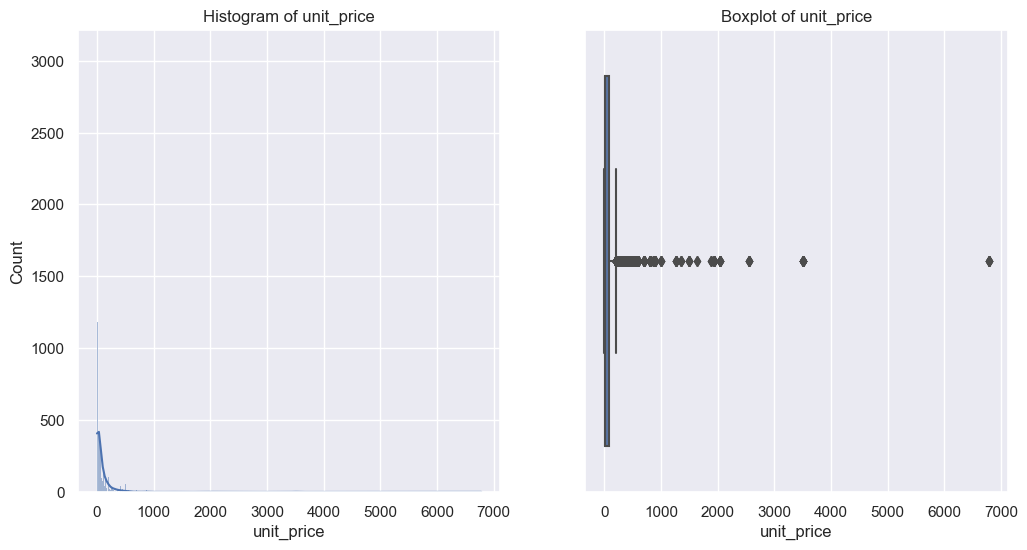

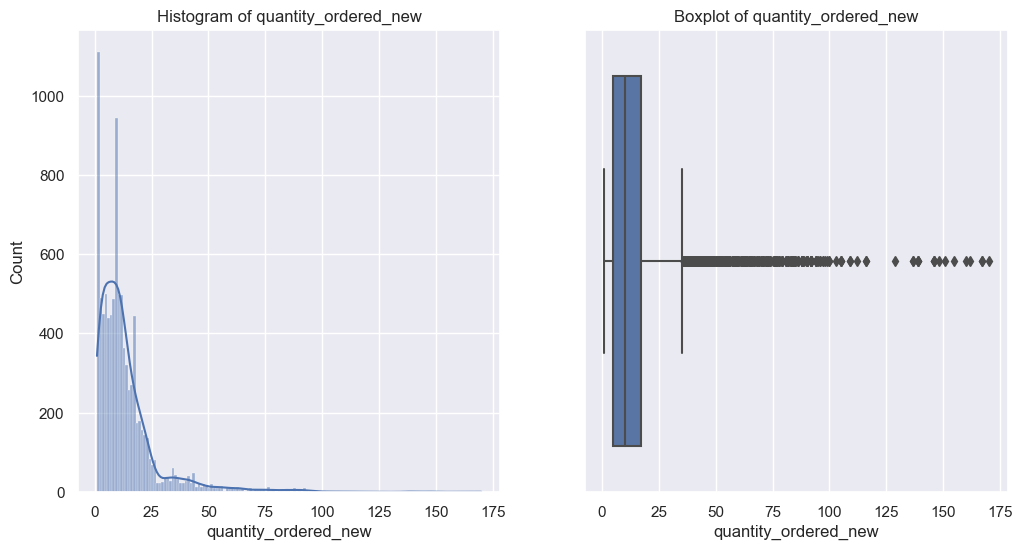

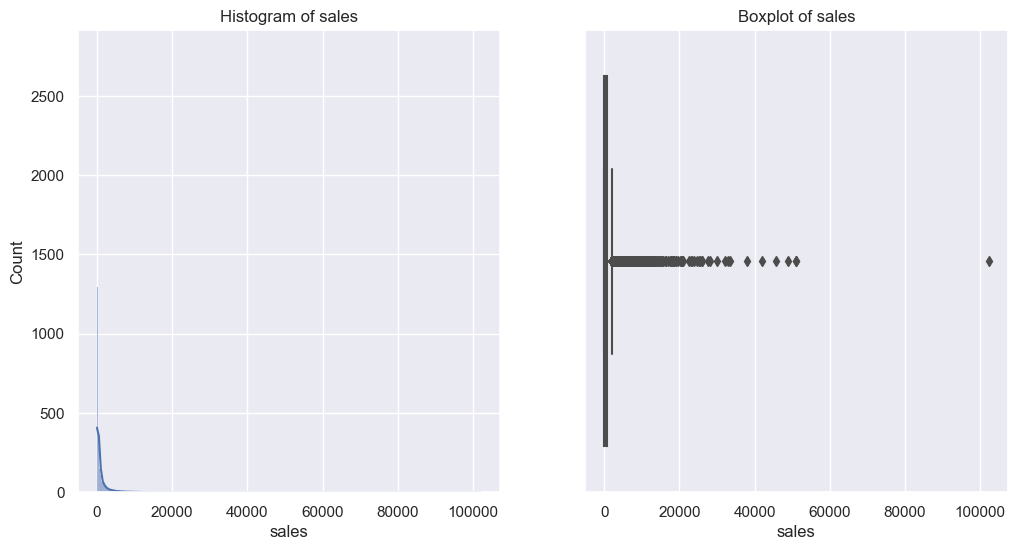

In [116]:
data = df.select_dtypes("number").drop(["order_id", "customer_id", "month"], axis=1)

for col in data:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    sns.histplot(df[col], ax=axes[0], kde=True)
    sns.boxplot(x=df[col], ax=axes[1])
    
    axes[0].set_title(f"Histogram of {col}")
    axes[1].set_title(f"Boxplot of {col}")
    plt.show();

### Categorical Columns Distribution

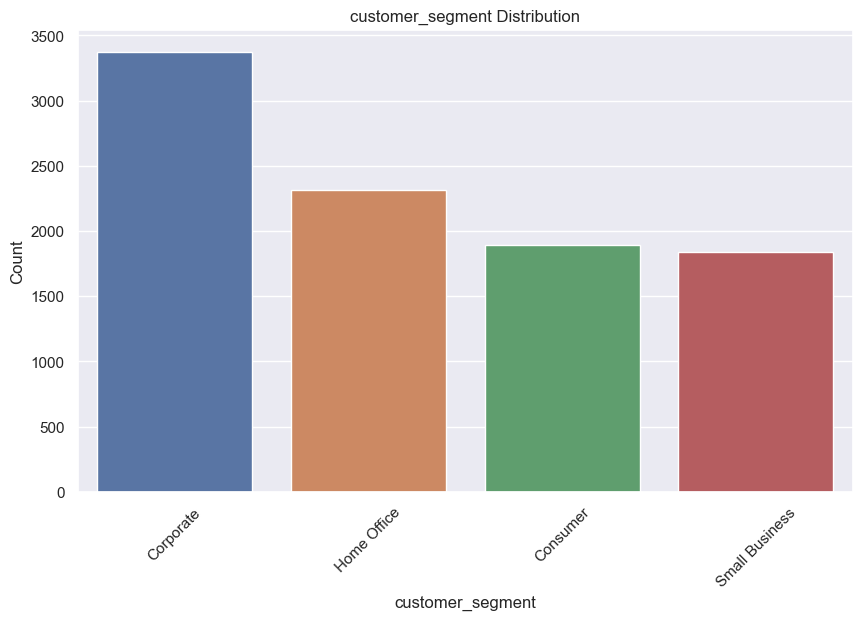

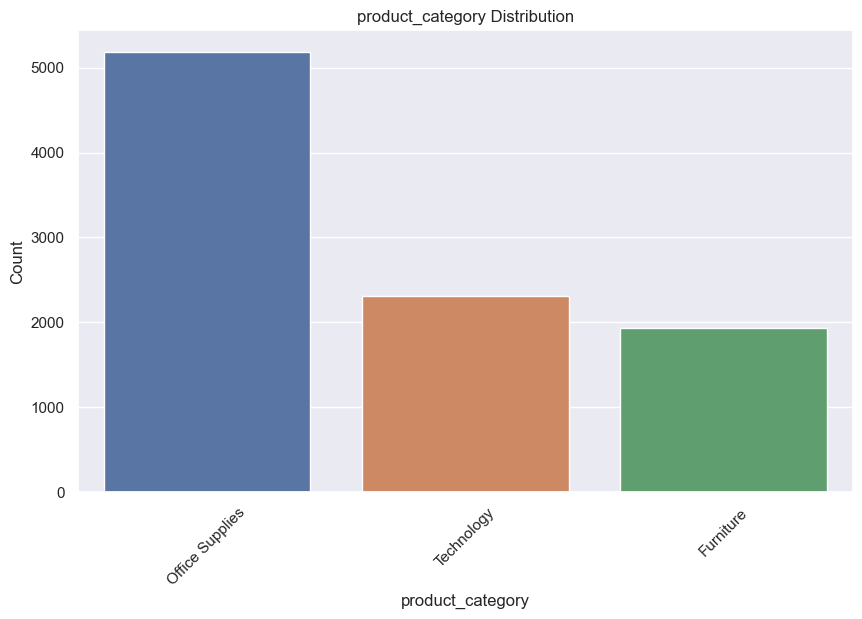

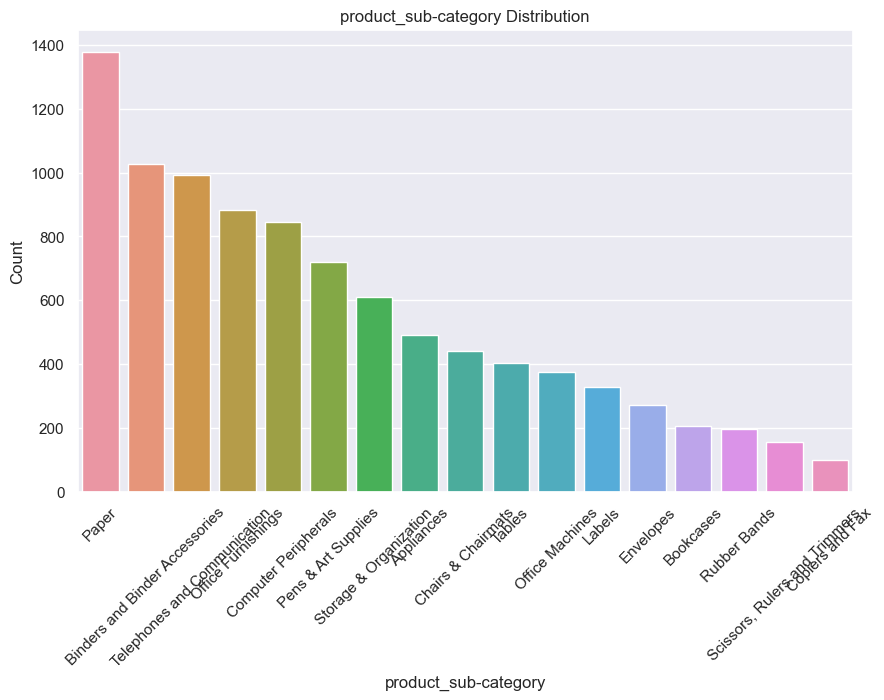

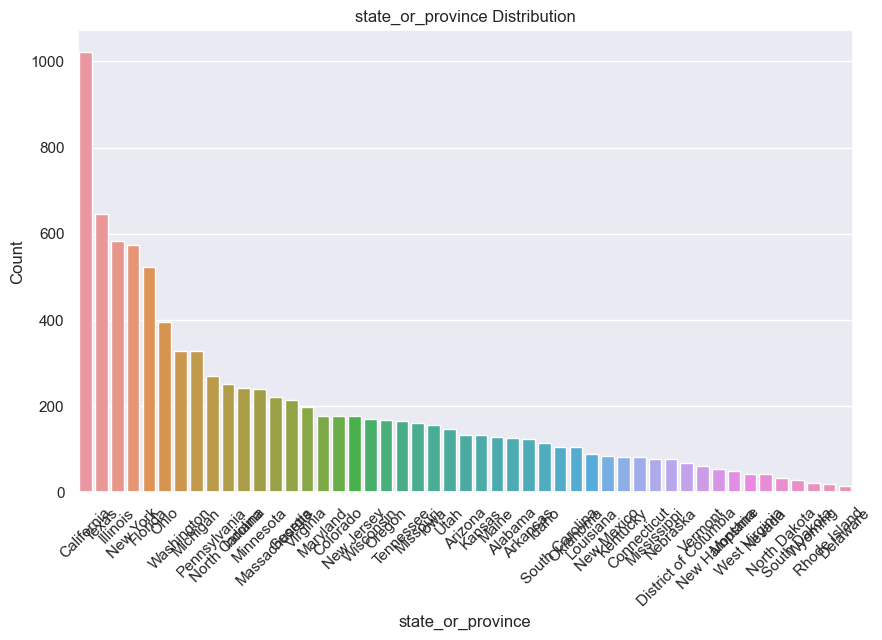

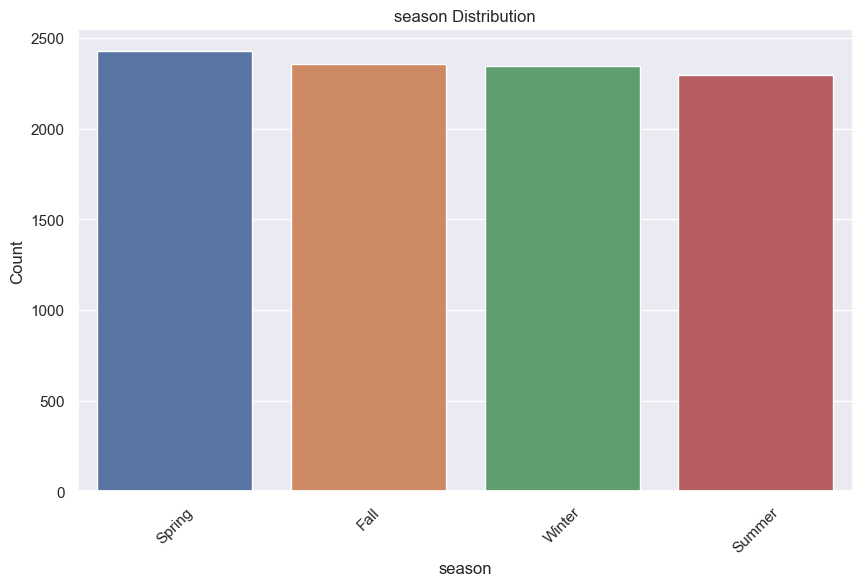

In [117]:
for col in df.select_dtypes("object").columns:
    data = df[col].value_counts().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=data, x=col, y="count") 
    
    plt.title(f"{col} Distribution")
    plt.xlabel(f"{col}")
    plt.ylabel("Count")
    
    plt.xticks(rotation=45)
    plt.show();

Actions: Removed anomalously high sales rows and combined customer categories.

In [118]:
df = df.query("sales < 60000")

# customer type
type_of_customers = {
    "Corporate": "Business",
    "Small Business": "Business",
    "Home Office": "Home",
    "Consumer": "Home"
}

df["customer_type"] = df["customer_segment"].map(type_of_customers)

## Feature Engineering and Creating a Single Row per Customer

### Recency, Frequency, Monetary value columns

In [119]:
current_date = pd.Timestamp("2014-01-01")

customer_orders = (
    df.groupby(["customer_id", "order_id"])
    .agg(n_items=("quantity_ordered_new", "sum"), total_sale=("sales", "sum"), order_date=("order_date", "max"))
    .reset_index()
)

In [120]:
customers = (
    customer_orders.groupby("customer_id")
    .agg(
        recency=("order_date", lambda x: (current_date - x.max()).days),
		frequency=("order_id", "count"), monetary=("total_sale", "sum"),
        total_items=("n_items", "sum")
	).reset_index()
)

customers.drop("total_items", axis=1, inplace=True)

### Category sales

In [121]:
categories = (
    df[["customer_id", "sales", "product_category"]].drop_duplicates()
    .groupby(["customer_id", "product_category"])
    ["sales"].sum().to_frame("sales").reset_index()
)

categories = categories.pivot(index="customer_id", columns="product_category", values="sales").reset_index().fillna(0)
categories_cols = {col: col.lower().replace(" ", "_") + "_sales" for col in categories.columns[1:]}
categories.rename(columns=categories_cols, inplace=True)

In [122]:
customer_type = pd.pivot_table(data=df, index="customer_id", columns="customer_type", values="order_id", aggfunc="nunique", fill_value=0).reset_index()
customer_type_cols = {col: col.lower().replace(" ", "_") + "_orders" for col in customer_type.columns[1:]}
customer_type.rename(columns=customer_type_cols, inplace=True)

### Seasonality

In [123]:
season = pd.pivot_table(data=df, index="customer_id", columns="season", values="sales", aggfunc="sum", fill_value=0).reset_index()
season_type_cols = {col: col.lower().replace(" ", "_") + "_sales" for col in season.columns[1:]}
season.rename(columns=season_type_cols, inplace=True)

### Final Output

In [124]:
state = df[["customer_id", "state_or_province"]].drop_duplicates()

for data in [categories, customer_type, season, state]:
    customers = customers.merge(data, on="customer_id", how="left")

In [125]:
customers.head(10)

,customer_id,recency,frequency,monetary,furniture_sales,office_supplies_sales,technology_sales,business_orders,home_orders,fall_sales,spring_sales,summer_sales,winter_sales,state_or_province
0,2,583,1,5.76,0.00,5.76,0.00,1,0,0.00,5.76,0.00,0.00,Illinois
1,3,184,4,5250.20,0.00,2150.64,3099.56,4,0,2052.76,0.00,3197.44,0.00,Washington
2,5,599,2,6128.40,6011.76,116.64,0.00,0,2,0.00,116.64,0.00,6011.76,California
3,6,368,2,3615.80,0.00,1552.04,2063.76,0,2,0.00,1443.84,0.00,2171.96,California
4,7,428,1,233.32,0.00,233.32,0.00,0,1,233.32,0.00,0.00,0.00,Massachusetts
5,8,372,1,704.90,704.90,0.00,0.00,0,1,0.00,0.00,0.00,704.90,New Hampshire
6,9,372,1,2294.80,2294.80,0.00,0.00,0,1,0.00,0.00,0.00,2294.80,New Jersey
7,10,820,1,217.98,0.00,217.98,0.00,0,1,217.98,0.00,0.00,0.00,New Jersey
8,11,1235,1,208.56,208.56,0.00,0.00,0,1,0.00,0.00,208.56,0.00,New Jersey
9,12,677,1,87.84,0.00,87.84,0.00,0,1,0.00,0.00,0.00,87.84,Rhode Island


### Export Data for Modeling

In [127]:
customers.to_csv("data.csv", index=False)